In [59]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [60]:
import pandas as pd

# Cargar los datos
df = pd.read_csv('..\data\procesed\df_master_clean.csv')
print(df.shape)
df.columns


(100466, 68)


Index(['nit_enmascarado', 'num_oblig_orig_enmascarado',
       'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt',
       'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons',
       'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora',
       'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento',
       'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3',
       'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2',
       'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc',
       'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo',
       'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult',
       'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli',
       'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes',
       'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora',
       'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago',
      

In [61]:
df_tr = pd.read_csv(r"..\data\raw\prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv")
print(df_tr.shape)
df_tr.columns.sort_values()

(568251, 49)


Index(['alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2',
       'alternativa_aplicada_agr', 'aplicativo', 'banca', 'cant_acuerdo',
       'cant_acuerdo_binario', 'cant_alter_posibles', 'cant_gestiones',
       'cant_gestiones_binario', 'cant_promesas_cumplidas_binario',
       'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3',
       'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult',
       'dias_mora_fin', 'endeudamiento', 'fecha_var_rpta_alt',
       'marca_agrupada_rgo', 'marca_alt_apli', 'marca_alt_rank',
       'marca_alternativa', 'marca_alternativa_orig', 'marca_debito_mora',
       'marca_pago', 'max_mora', 'min_mora', 'nit_enmascarado',
       'num_oblig_enmascarado', 'num_oblig_orig_enmascarado', 'pago_cuota',
       'pago_mes', 'pagos_tanque', 'porc_pago_cuota', 'porc_pago_mes',
       'producto', 'producto_cons', 'promesas_cumplidas', 'rango_mora', 'rpc',
       'saldo_capital', 'segmento', 'tipo_var_rpta_alt', 'valor_cuota_mes',
       '

In [62]:
# Seleccionar las columnas que están en la intersección y agregar 'id' si existe en df
columns_to_keep = df.columns.intersection(df_tr.columns).tolist()

# Agregar 'id' si está presente en df
if 'id' in df.columns:
    columns_to_keep.append('id')

# Filtrar el DataFrame
df = df[columns_to_keep]

df.drop(columns=['tipo_var_rpta_alt'], inplace=True, axis=1)

In [63]:
# Eliminar columnas de fechaQ
X = df.drop(columns=['var_rpta_alt', 'id'])

# Variable objetivo
y = df['var_rpta_alt']

In [64]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (100466, 47)
y shape: (100466,)


In [65]:
# Supongamos que ya definiste X (features) y y (target)
# Define columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combinamos todo en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplica la transformación
X_preprocessed = preprocessor.fit_transform(X)
print(f"X_preprocessed shape: {X_preprocessed.shape}")

X_preprocessed shape: (100466, 218)


In [66]:
# 1. Reconstruir nombres de columnas transformadas
numeric_features_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features_names + categorical_feature_names.tolist()

# 2. Convertir X_preprocessed a DataFrame
X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=all_feature_names,
    index=X.index
)

# 3. Calcular matriz de correlación absoluta
corr_matrix = X_preprocessed_df.corr().abs()

# 4. Máscara triangular superior
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 5. Identificar columnas altamente correlacionadas
correlation_threshold = 0.9
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

print(f"📌 Variables eliminadas por colinealidad (corr > {correlation_threshold}): {len(high_corr_cols)}")

# 6. Eliminar columnas del DataFrame
X_nocolineal = X_preprocessed_df.drop(columns=high_corr_cols)

print(f"✅ X_preprocessed shape original: {X_preprocessed_df.shape}")
print(f"✅ X_nocolineal shape final: {X_nocolineal.shape}")

📌 Variables eliminadas por colinealidad (corr > 0.9): 69
✅ X_preprocessed shape original: (100466, 218)
✅ X_nocolineal shape final: (100466, 149)


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Modelo Lasso (L1)
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    C=1.0  # puedes ajustar este valor
)
lasso_model.fit(X_nocolineal, y)

# Umbral dinámico: mínimo coef diferente de 0
non_zero_coefs = lasso_model.coef_[0][lasso_model.coef_[0] != 0]
min_non_zero_coef = np.min(np.abs(non_zero_coefs)) - 1e-6

# Selección con umbral ajustado
selector = SelectFromModel(estimator=lasso_model, prefit=True, threshold=min_non_zero_coef)
X_selected = selector.transform(X_nocolineal)

print(f"Features seleccionadas: {X_selected.shape[1]} de {X_nocolineal.shape[1]}")

Features seleccionadas: 44 de 149


d:\Desktop\juan_guzma_prueba_banco\env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [68]:
print(f"Características seleccionadas: {X_selected.shape[1]} de {X_nocolineal.shape[1]}")

Características seleccionadas: 44 de 149


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Obtener nombres de columnas después del preprocesamiento
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
final_feature_names = numeric_features + list(onehot_feature_names)

# Coeficientes del modelo
coefficients = lasso_model.coef_[0]  # para clasificación binaria

# Crear DataFrame con nombres y coeficientes
coef_df = pd.DataFrame({
    'feature': final_feature_names,
    'coefficient': coefficients
})

# Filtrar solo los coeficientes diferentes de 0 (es decir, seleccionados por Lasso)
coef_df = coef_df[coef_df['coefficient'] != 0]

# Ordenar por valor absoluto del coeficiente
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Mostrar DataFrame
coef_df[['feature', 'coefficient']].head(20)

ValueError: All arrays must be of the same length

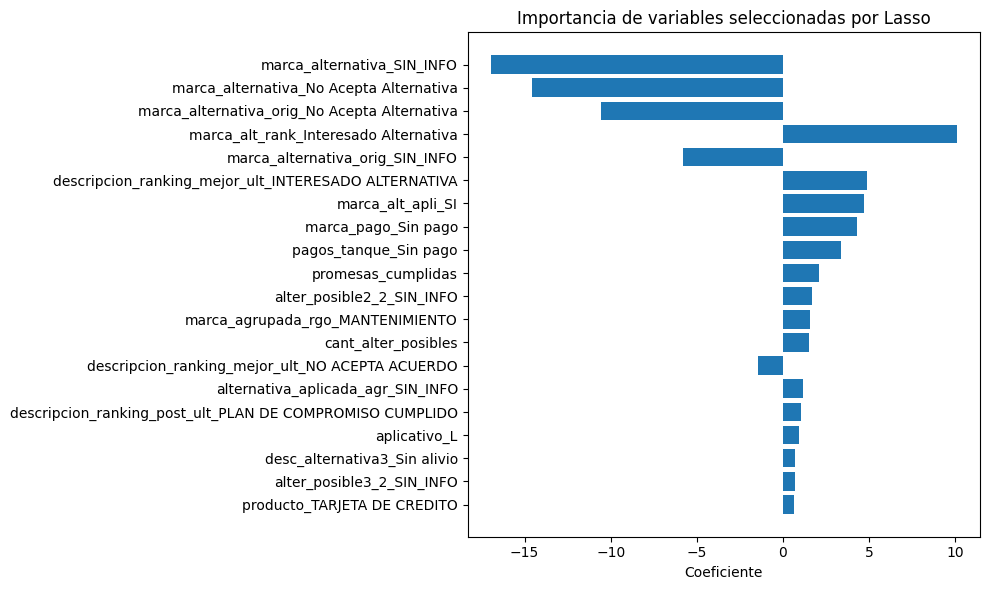

In [ ]:
# Graficar
plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'].iloc[:20], coef_df['coefficient'].iloc[:20])
plt.xlabel('Coeficiente')
plt.title('Importancia de variables seleccionadas por Lasso')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 🎯 Interpretación de las 20 variables más importantes seleccionadas por Lasso

| **#** | **Variable** | **Coeficiente** | **Interpretación** |
|------|--------------|-----------------|--------------------|
| 1 | `tipo_var_rpta_alt_c_uno_tipo_3` | +9.27 | Tipo de alternativa fuertemente asociado con **aceptación** de la alternativa. |
| 2 | `tipo_var_rpta_alt_b_uno_tipo_2` | +8.95 | También impulsa la probabilidad de aceptación. |
| 3 | `tipo_var_rpta_alt_d_cero_tipo_1` | -7.05 | Este tipo reduce fuertemente la probabilidad de aceptación. |
| 4 | `marca_alt_apli_SI` | +5.58 | Si se aplicó la alternativa, el cliente muy probablemente aceptó. Puede haber causalidad inversa. |
| 5 | `tipo_var_rpta_alt_e_cero_tipo_2` | -4.67 | Este tipo específico se asocia con menor probabilidad de aceptación. |
| 6 | `marca_alt_rank_Interesado Alternativa` | +4.59 | Cliente fue marcado como interesado — fuerte predictor positivo. |
| 7 | `marca_alternativa_orig_No Acepta Alternativa` | -3.81 | Historia previa de rechazo — predictor negativo. |
| 8 | `marca_alternativa_SIN_INFO` | -3.81 | Falta de información se relaciona con menor aceptación. |
| 9 | `marca_agrupada_rgo_MANTENIMIENTO` | +2.84 | Operación de tipo mantenimiento se asocia con mayor probabilidad de aceptación. |
|10 | `marca_alternativa_No Acepta Alternativa` | -2.36 | Rechazo explícito afecta negativamente la aceptación futura. |
|11 | `marca_agrupada_rgo_MODIFICACIÓN` | +2.11 | Segmento de modificación asociado positivamente. |
|12 | `marca_agrupada_rgo_CONSOLIDACION` | +1.55 | Consolidación está relacionada con mayor aceptación. |
|13 | `marca_alternativa_orig_SIN_INFO` | -1.49 | Falta de datos en la alternativa original afecta negativamente. |
|14 | `marca_agrupada_rgo_REESTRUCTURACIÓN` | +1.27 | Reestructuración en general es positiva para aceptación. |
|15 | `marca_alt_rank_No acepta acuerdo` | -1.09 | Comportamiento previo de rechazo a acuerdos reduce probabilidad. |
|16 | `descripcion_ranking_mejor_ult_ACEPTA ALTERNATIVA` | +0.93 | Historial de aceptación es buen predictor. |
|17 | `descripcion_ranking_mejor_ult_INTERESADO ALTERNATIVA` | +0.92 | Cliente se mostró interesado previamente. |
|18 | `cant_promesas_cumplidas_binario` | +0.79 | Clientes que cumplen promesas son más propensos a aceptar. |
|19 | `descripcion_ranking_post_ult_ACEPTA ALTERNATIVA` | +0.76 | El comportamiento posterior refuerza la intención de aceptar. |
|20 | `desc_alternativa3_Consolidación de pasivos` | +0.73 | Tener como opción consolidar pasivos es predictor positivo. |

> 💡 **Nota**: Los coeficientes positivos indican mayor probabilidad de que el cliente acepte la alternativa (`var_rpta_alt = 1`), mientras que los negativos indican lo contrario.


In [ ]:
coef_df[['feature']].to_csv(r'..\data\procesed\features.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

# 1. Obtener nombres de las variables preprocesadas
numeric_features_names = numeric_features
categorical_features_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features_names + categorical_features_names.tolist()

# 2. Convertir X_nocolineal a DataFrame completo
X_nocolineal_df = pd.DataFrame(
    X_nocolineal.toarray() if hasattr(X_nocolineal, "toarray") else X_nocolineal,  # por si es sparse
    columns=all_feature_names,
    index=X.index
)

# 3. Obtener máscara de variables seleccionadas por Lasso
selected_mask = selector.get_support()
selected_features = np.array(all_feature_names)[selected_mask]

# 4. Crear df_final con columnas seleccionadas + y + id
df_final = pd.concat([
    df[['id']],                      # columna ID original
    y,                               # target
    X_nocolineal_df[selected_features]  # features seleccionadas
], axis=1)

# 5. Exportar a CSV
df_final.to_csv(r'..\data\procesed\df_procesed.csv', index=False)

print("✅ DataFrame final exportado exitosamente.")
print(f"Shape final: {df_final.shape}")

✅ DataFrame final exportado exitosamente.
Shape final: (100466, 46)


In [ ]:
df_final.head()

,id,var_rpta_alt,nit_enmascarado,dias_mora_fin,vlr_obligacion,endeudamiento,cant_alter_posibles,cant_gestiones,rpc,promesas_cumplidas,...,marca_agrupada_rgo_MANTENIMIENTO,marca_agrupada_rgo_MODIFICACIÓN,marca_agrupada_rgo_SIN_INFO,marca_pago_Pago Total,marca_pago_Pago parcial,marca_pago_Sin pago,marca_alternativa_No Acepta Alternativa,marca_alternativa_SIN_INFO,marca_alternativa_orig_No Acepta Alternativa,marca_alternativa_orig_SIN_INFO
0,59412#789567#290775,1,-1.369510,-1.115384,-0.078948,-0.367096,0.214128,-0.923399,0.264671,-0.276478,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,277595#1045909#34433,1,-0.172466,0.647530,3.396851,1.023520,1.370593,1.003335,-3.778274,-0.276478,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,487939#390004#689862,0,0.981571,-0.328853,-0.105346,-0.474116,-0.942337,2.352048,0.264671,-0.276478,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,464338#811845#268497,0,0.852086,-0.220366,0.000484,-0.416099,-0.942337,0.521651,0.264671,-0.276478,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,147234#366139#713712,0,-0.887681,0.891626,-0.442432,-0.074652,1.370593,-0.345379,0.264671,-0.276478,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [57]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100466 entries, 0 to 100465
Data columns (total 46 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   id                                                        100466 non-null  object 
 1   var_rpta_alt                                              100466 non-null  int64  
 2   nit_enmascarado                                           100466 non-null  float64
 3   dias_mora_fin                                             100466 non-null  float64
 4   vlr_obligacion                                            100466 non-null  float64
 5   endeudamiento                                             100466 non-null  float64
 6   cant_alter_posibles                                       100466 non-null  float64
 7   cant_gestiones                                            100466 non-null  float64
 8   rpc 

##################################################

In [70]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os

In [71]:
# =============================
# 1. Cargar y limpiar los datos
# =============================

# Cargar dataset preprocesado y el base train/test
df = pd.read_csv('../data/procesed/df_master_clean.csv')
df_tr = pd.read_csv('../data/raw/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')

# Filtrar columnas comunes + 'id'
columns_to_keep = df.columns.intersection(df_tr.columns).tolist()
if 'id' in df.columns:
    columns_to_keep.append('id')
df = df[columns_to_keep]

# Eliminar columna no deseada si existe
df.drop(columns=['tipo_var_rpta_alt'], inplace=True, errors='ignore')

# Separar variables independientes y objetivo
X = df.drop(columns=['var_rpta_alt', 'id'])
y = df['var_rpta_alt']

print(f"🔹 X shape: {X.shape}")
print(f"🔹 y shape: {y.shape}")


🔹 X shape: (100466, 47)
🔹 y shape: (100466,)


In [72]:
# ================================
# 2. Preprocesamiento con Pipeline
# ================================

# Identificar tipos de columnas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplicar transformaciones
X_preprocessed = preprocessor.fit_transform(X)
print(f"🔹 X_preprocessed shape: {X_preprocessed.shape}")

🔹 X_preprocessed shape: (100466, 218)


In [73]:
# ==================================
# 3. Eliminar colinealidad (> 0.9)
# ==================================

# Reconstruir nombres de columnas transformadas
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(onehot_feature_names)

# Convertir a DataFrame
X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=all_feature_names,
    index=X.index
)

# Calcular matriz de correlación
corr_matrix = X_preprocessed_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Eliminar una de cada par altamente correlacionado
correlation_threshold = 0.9
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

print(f"📌 Variables eliminadas por colinealidad: {len(high_corr_cols)}")
X_nocolineal = X_preprocessed_df.drop(columns=high_corr_cols)

print(f"✅ Shape después de quitar colinealidad: {X_nocolineal.shape}")


📌 Variables eliminadas por colinealidad: 69
✅ Shape después de quitar colinealidad: (100466, 149)


In [74]:
# ======================================
# 4. Selección de variables con Lasso
# ======================================

# Entrenar modelo L1
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    C=1.0
)
lasso_model.fit(X_nocolineal, y)

# Umbral para coeficientes ≠ 0
non_zero_coefs = lasso_model.coef_[0][lasso_model.coef_[0] != 0]
min_non_zero_coef = np.min(np.abs(non_zero_coefs)) - 1e-6

# Aplicar selección
selector = SelectFromModel(estimator=lasso_model, prefit=True, threshold=min_non_zero_coef)
X_selected = selector.transform(X_nocolineal)
selected_mask = selector.get_support()
selected_features = np.array(X_nocolineal.columns)[selected_mask]

print(f"✅ Variables seleccionadas por Lasso: {X_selected.shape[1]} de {X_nocolineal.shape[1]}")


✅ Variables seleccionadas por Lasso: 44 de 149


d:\Desktop\juan_guzma_prueba_banco\env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


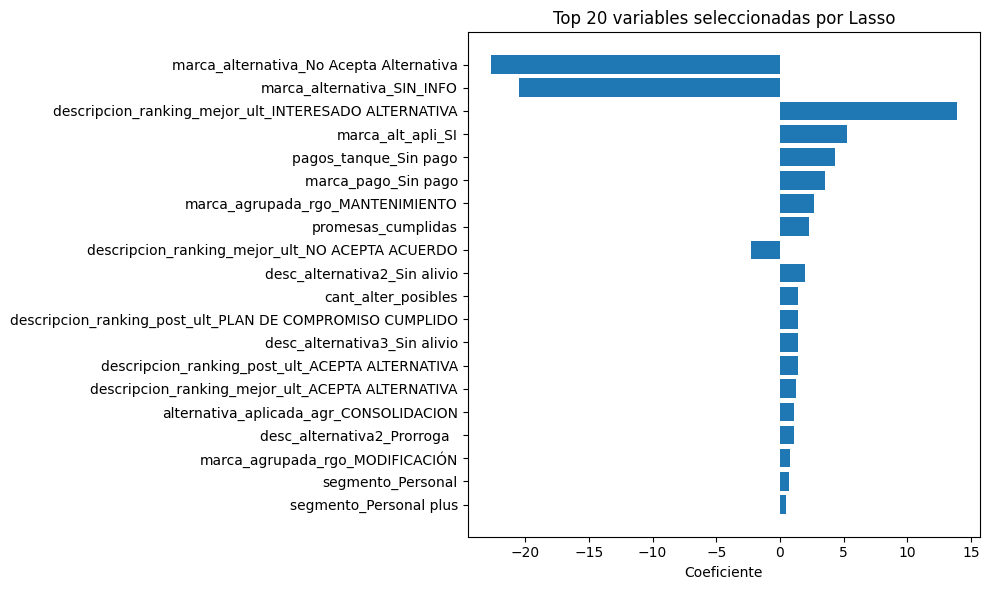

In [75]:
# ==========================================
# 5. Exportar ranking de variables Lasso
# ==========================================

coefficients = lasso_model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_nocolineal.columns,
    'coefficient': coefficients
})
coef_df = coef_df[coef_df['coefficient'] != 0]
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Graficar top 20
plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'].iloc[:20], coef_df['coefficient'].iloc[:20])
plt.xlabel('Coeficiente')
plt.title('Top 20 variables seleccionadas por Lasso')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Exportar ranking
os.makedirs('../data/procesed', exist_ok=True)
coef_df[['feature']].to_csv('../data/procesed/features.csv', index=False)

In [76]:
# ===================================
# 6. Exportar DataFrame final limpio
# ===================================

# Crear DataFrame final
X_nocolineal_df = X_nocolineal.copy()
df_final = pd.concat([
    df[['id']],
    y,
    X_nocolineal_df[selected_features]
], axis=1)

df_final.to_csv('../data/procesed/df_procesed.csv', index=False)
print(f"✅ DataFrame final exportado. Shape: {df_final.shape}")

✅ DataFrame final exportado. Shape: (100466, 46)
